#Автоматическая обработка документов. Распознавание штрихкодов.
**Автор**: Мельникова Елена

**Группа**: M05-316б

#Установка библиотек

In [ ]:
# !pip install pytorch_lightning
# !pip install segmentation_models_pytorch
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pytorch_lightning.callbacks import Callback, ModelCheckpoint, LearningRateMonitor

In [ ]:
from google.colab import drive
import os
import pandas as pd
from torch.utils.data import Dataset
import cv2
import numpy as np
import torch
import albumentations as A
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn.functional as F
import torch.nn as nn

#Загрузка данных

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
_, _, Train_Images = next(os.walk("/content/drive/MyDrive/CourseOCRTask3/Train/Images"))
Train_Images_count = len(Train_Images)
print(f'Количество изображений в папке трейна = {Train_Images_count}')

Количество изображений в папке трейна = 8405


In [ ]:
names = ['img_id', 'barcode', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'unicode']
df = pd.read_csv("/content/drive/MyDrive/CourseOCRTask3/Train/markup.csv", encoding='utf-16', names = names).drop('unicode', axis=1)
print(f'Размер размеченной трейновой выборки = {len(df)}')
df.head()

Размер размеченной трейновой выборки = 8199


,img_id,barcode,x1,y1,x2,y2,x3,y3,x4,y4
0,fc272e4092ccb147a31e66bc1d10fbfb.png,3601514743345,538,248,1590,225,1597,663,532,676
1,8cde8cb1b54bca37c9347baf74157d22.png,7000001062307,372,433,360,1289,124,1293,147,431
2,70a9be0887eae17eabd70c8e607f963f.png,2250001407126,408,230,1224,229,1224,688,414,683
3,a029e49dff95a15d2cd396d8f62220c8.png,10101427156,335,149,1005,155,1005,438,335,447
4,82ff01909b6d215170dfc26c7be43074.png,2400745402226,469,237,1388,260,1392,712,464,696


#Локализация баркода

##Подготовка трейна

In [ ]:
loc_df = df.drop('barcode', axis=1)

In [ ]:
loc_df.head()

,img_id,x1,y1,x2,y2,x3,y3,x4,y4
0,fc272e4092ccb147a31e66bc1d10fbfb.png,538,248,1590,225,1597,663,532,676
1,8cde8cb1b54bca37c9347baf74157d22.png,372,433,360,1289,124,1293,147,431
2,70a9be0887eae17eabd70c8e607f963f.png,408,230,1224,229,1224,688,414,683
3,a029e49dff95a15d2cd396d8f62220c8.png,335,149,1005,155,1005,438,335,447
4,82ff01909b6d215170dfc26c7be43074.png,469,237,1388,260,1392,712,464,696


In [ ]:
observation_transform = A.Compose(
    [
        A.Resize(512, 512),
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

In [ ]:
class SegmentationDataset(Dataset):
    def __init__(
        self,
        dataset,
        with_points=False,
        transform=None,
    ):
        if with_points:
          self.ann_df = dataset
          columns = ['img_id', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4']
        else:
          self.ann_df = dataset
          columns = []
        self.ann_df["img_width"] = [0] * len(self.ann_df)
        self.ann_df["img_height"] = [0] * len(self.ann_df)
        self.transform = transform
        self.feature_columns = columns[1:]

    def create_binary_mask(self, rectangle_points, image_shape):
      mask = np.zeros(image_shape, dtype=np.uint8)
      rectangle_points = np.array(rectangle_points, np.int32)
      rectangle_points = rectangle_points.reshape((-1, 1, 2))
      cv2.fillPoly(mask, [rectangle_points], color=(255, 255, 255))

      mask = (mask > 0).astype(np.int64)

      return mask

    def __len__(self):
        return self.ann_df.shape[0]

    def __getitem__(self, index):
        row = self.ann_df.iloc[index]

        ## read image
        # image = cv2.imread(f'/content/drive/MyDrive/CourseOCRTask3/Train/Images/{row["img_id"]}')
        image = cv2.imread(f'/content/drive/MyDrive/CourseOCRTask3/Test/Images/{row["img_id"]}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        h, w, _ = image.shape
        self.ann_df.loc[index, "img_width"] = w
        self.ann_df.loc[index, "img_height"] = h
        if len(self.feature_columns) > 0:
            features = row[self.feature_columns].values.astype(np.float32)
        if self.transform:
            if len(self.feature_columns) > 0:
                keypoints = features.reshape((len(features) // 2, 2))
                transformed = self.transform(image=image, keypoints = keypoints)
                image = transformed["image"]
                features = transformed["keypoints"]
                mask = self.create_binary_mask(features, (512, 512))
                mask = torch.from_numpy(mask).unsqueeze(0)
            else:
                transformed = self.transform(image=image, keypoints = [])
                image = transformed["image"]

        if len(self.feature_columns) > 0:
            return image, mask
        else:
            return image, None

In [ ]:
observation_train = SegmentationDataset(loc_df, with_points=True, transform=observation_transform)

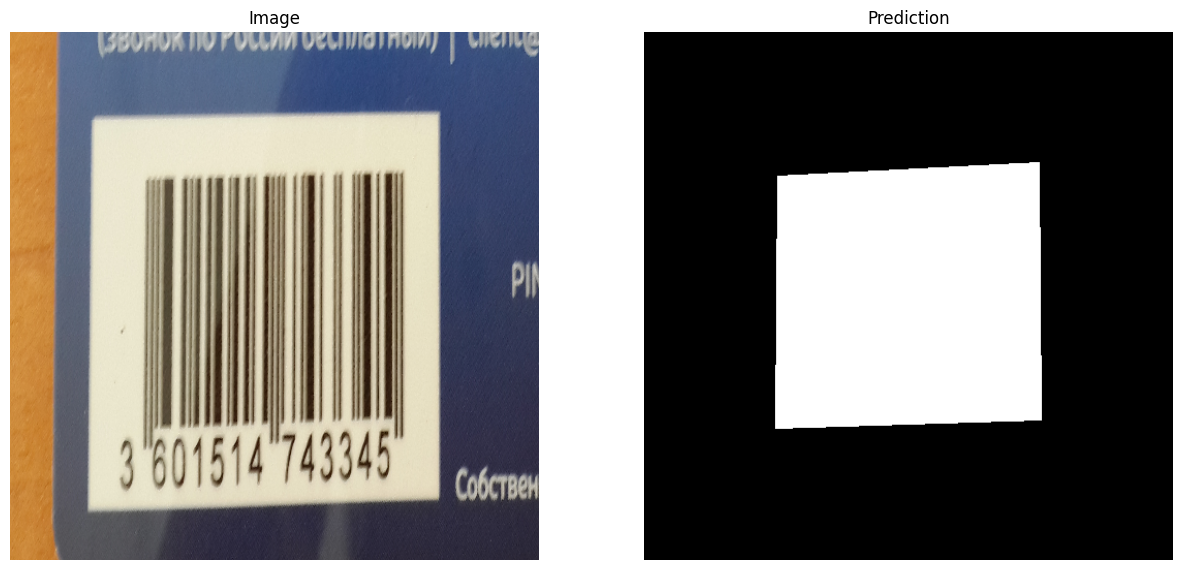

In [ ]:
for img, mask in observation_train:
    plt.figure(figsize=(15, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Image")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap = "gray")
    plt.title("Prediction")
    plt.axis("off")

    break

##Гиперпараметры

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

MEAN = (0.4914, 0.4822, 0.4465)
STD = (0.2023, 0.1994, 0.2010)

TRAIN_SUBPART = 1.0
VAL_SPLIT = 0.15

BATCH_SIZE = 32
DEFAULT_TRANSFORM = A.Compose(
    [
        A.Resize(512, 512),
        A.Normalize(mean=MEAN, std=STD),
        ToTensorV2()
    ],
    keypoint_params=A.KeypointParams(format='xy', remove_invisible=False)
)

##Классы и функции для модели и обучения

In [ ]:
def dice_coef(mask_pred_prob, mask_gt, threshold=0.5):
    mask_pred = (mask_pred_prob > threshold) * 1
    b = mask_pred.sum() + mask_gt.sum()
    if b == 0:
        return 1
    a = (mask_pred[mask_gt > 0]).sum() * 2.0
    return a / b


class LightningDocumentSegmenter(pl.LightningModule):
    def __init__(
        self,
        encoder_name,
        arch,
        train_batches,
        lr_rate=5e-4,
        warmup_batches=0,
        scheduler_patience=2,
        scheduler_factor=0.5,
        weight_decay=1e-2,
        max_epochs=6,
    ):
        super(LightningDocumentSegmenter, self).__init__()

        self.model = smp.create_model(
            arch, encoder_name=encoder_name, in_channels=3, classes=1
        )
        self.lr_rate = lr_rate
        self.train_loss = []
        self.val_loss = []
        self.lrs = []
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        self.save_hyperparameters()
        self.warmup_steps = warmup_batches
        self.train_steps = train_batches
        self.scheduler_patience = scheduler_patience
        self.scheduler_factor = scheduler_factor
        self.weight_decay = weight_decay
        self.max_epochs = max_epochs

    def forward(self, x):
        return self.model(x)

    def __log_metrics(self, logits_mask, mask, loss, mode):
        probs = logits_mask.sigmoid()
        tp, fp, fn, tn = smp.metrics.get_stats(
            probs, mask, mode="binary", threshold=0.5
        )
        iou_score = smp.metrics.iou_score(tp, fp, fn, tn, reduction="micro")
        dice = dice_coef(probs, mask)
        metrics_dict = {f"{mode}_iou": iou_score, f"{mode}_dice": dice}
        self.log_dict(metrics_dict, on_step=False, on_epoch=True)
        if loss is not None:
            self.log(f"{mode}_loss", loss, on_step=False, on_epoch=True, prog_bar=False)

    def training_step(self, train_batch, batch_idx):
        x, mask = train_batch
        logits_mask = self.forward(x)
        loss = self.loss_fn(logits_mask, mask)
        self.train_loss.append(loss.item())

        self.__log_metrics(logits_mask, mask, loss, "train")

        current_lr = self.optimizers().param_groups[0]["lr"]
        self.log("lr", current_lr, on_step=True, on_epoch=False, prog_bar=False)
        self.lrs.append(current_lr)
        return {"loss": loss}

    def validation_step(self, val_batch, batch_idx):
        x, mask = val_batch
        logits_mask = self.forward(x)
        loss = self.loss_fn(logits_mask, mask)
        self.val_loss.append(loss.item())

        self.__log_metrics(logits_mask, mask, loss, "val")

        return {"val_loss": loss}

    def test_step(self, val_batch, batch_idx):
        x, mask = val_batch
        logits_mask = self.forward(x)

        self.__log_metrics(logits_mask, mask, None, "test")

        return {}

    def on_train_epoch_end(self):
        avg_loss = np.mean(self.train_loss)
        print(
            f"\nEpoch {self.trainer.current_epoch}, "
            f"Train_loss: {round(float(avg_loss), 5)} "
        )
        self.train_loss.clear()

    def on_validation_epoch_end(self):
        avg_loss = np.mean(self.val_loss)
        print(
            f"\nEpoch {self.trainer.current_epoch}, "
            f"Val_loss: {round(float(avg_loss), 5)} "
        )
        self.val_loss.clear()

    def configure_optimizers(self):
        self.optimizer = torch.optim.AdamW(
            self.parameters(), lr=self.lr_rate, weight_decay=self.weight_decay
        )
        self.reduce_lr_on_plateau = {
            "scheduler": torch.optim.lr_scheduler.ReduceLROnPlateau(
                self.optimizer,
                factor=self.scheduler_factor,
                patience=self.scheduler_patience,
                min_lr=1e-7,
                verbose=True,
            ),
            "monitor": "val_loss",
            "interval": "epoch",
        }
        return [self.optimizer], [self.reduce_lr_on_plateau]

In [ ]:
class KeypointDataModule(pl.LightningDataModule):
    def __init__(
        self,
        dataset,
        batch_size=BATCH_SIZE,
        train_transform=DEFAULT_TRANSFORM,
    ):
        super().__init__()

        self.batch_size = batch_size

        self.train_set = SegmentationDataset(
            dataset = dataset,
            with_points = True,
            transform = train_transform
        )

        indices = list(range(len(self.train_set)))
        np.random.shuffle(indices)
        indices = indices[: int(round(len(indices) * TRAIN_SUBPART))]
        split = int(round(VAL_SPLIT * len(indices)))

        self.train_sampler = SubsetRandomSampler(indices[split:])
        self.val_sampler = SubsetRandomSampler(indices[:split])
        # self.test_sampler = SubsetRandomSampler(indices)

    def setup(self, stage):
        print(
            f"Train: {len(self.train_sampler)} images\n"
            f"Validation: {len(self.val_sampler)} images"
        )

    def train_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.train_sampler,
            batch_size=self.batch_size,
        )

    def val_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            sampler=self.val_sampler,
            batch_size=self.batch_size,
        )

    def test_dataloader(self):
        return torch.utils.data.DataLoader(
            self.train_set,
            # sampler=self.test_sampler,
            batch_size=self.batch_size,
        )

##Обучение

In [ ]:
data_module = KeypointDataModule(
        dataset = loc_df,
        batch_size=BATCH_SIZE,
        train_transform=DEFAULT_TRANSFORM,
    )

In [ ]:
MAX_EPOCHS = 5
BASE_LR = 1e-4
SCHEDULER_FACTOR = 0.1
SCHEDULER_PATIENCE = 2
WARMUP_STEPS = 0
WEIGHT_DECAY = 1e-2
num_train_batches = len(data_module.train_dataloader())

In [ ]:
!mkdir /content/drive/MyDrive/segm_checkpoints

mkdir: cannot create directory ‘/content/drive/MyDrive/segm_checkpoints’: File exists


In [ ]:
model = LightningDocumentSegmenter(
    encoder_name="resnet18",
    arch="Unet",
    train_batches=num_train_batches,
    lr_rate=BASE_LR,
    warmup_batches = WARMUP_STEPS,
    scheduler_patience = SCHEDULER_PATIENCE,
    scheduler_factor = SCHEDULER_FACTOR,
    weight_decay = WEIGHT_DECAY,
    max_epochs=MAX_EPOCHS,
)

checkpoint_callback = ModelCheckpoint(
    dirpath="/content/drive/MyDrive/segm_checkpoints",
    filename="{epoch}",
    monitor="val_loss",
    mode="min",
    save_top_k=1,
    save_last=1,
)

trainer = pl.Trainer(
    callbacks=[checkpoint_callback],
    max_epochs=MAX_EPOCHS,
    accelerator=DEVICE,
    devices=1,
    enable_progress_bar=False,
    gradient_clip_val=1
)

trainer.fit(model, data_module)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Train: 6969 images
Validation: 1230 images


INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type     | Params
-------------------------------------
0 | model   | Unet     | 14.3 M
1 | loss_fn | DiceLoss | 0     
-------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)



Epoch 0, Val_loss: 0.60981 

Epoch 0, Val_loss: 0.16082 

Epoch 0, Train_loss: 0.24726 

Epoch 1, Val_loss: 0.09109 

Epoch 1, Train_loss: 0.1187 

Epoch 2, Val_loss: 0.05941 

Epoch 2, Train_loss: 0.07226 

Epoch 3, Val_loss: 0.04483 

Epoch 3, Train_loss: 0.04985 

Epoch 4, Val_loss: 0.03565 

Epoch 4, Train_loss: 0.03755 


INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=5` reached.


##Просмотр результатов и перевод данных в нужный формат

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/ML-MountainLover/course_ocr.git

Cloning into 'course_ocr'...
remote: Enumerating objects: 222, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 222 (delta 59), reused 47 (delta 47), pack-reused 140
Receiving objects: 100% (222/222), 16.02 MiB | 15.79 MiB/s, done.
Resolving deltas: 100% (114/114), done.


In [ ]:
_, _, Test_Images = next(os.walk("/content/drive/MyDrive/CourseOCRTask3/Test/Images"))
print(Test_Images[84])
Test_Images = Test_Images[:84] + Test_Images[85:]
Test_Images_count = len(Test_Images)
print(f'Количество изображений в папке теста = {Test_Images_count}')

desktop.ini
Количество изображений в папке теста = 100


In [ ]:
names = ['img_id', 'barcode', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'unicode']
test_gt = pd.read_csv("/content/course_ocr/task3/markup.csv", encoding='utf-16', names = names)
print(f'Размер ground truth разметки изображений из Test = {len(test_gt)}')
test_gt.head()

Размер ground truth разметки изображений из Test = 100


,img_id,barcode,x1,y1,x2,y2,x3,y3,x4,y4,unicode
0,5825c9d1deb6572b6dba440d5c6482bf.png,2005003708814,569,485,1644,452,1707,1335,583,1356,1010001101000110101110010100111000110101000010...
1,f9bf5d96a0cf5d64aac4eb5806554224.png,8594015301013,686,446,1833,528,1747,1338,611,1117,1010110001001011101000110100111011001101100010...
2,a154b624c06072da1a01c97ebc3894c1.png,4607016245676,536,483,1552,313,1608,767,620,939,1010101111010011101110110001101011001100001010...
3,749003091876fc58be69db54bbaae8f1.png,4602824019426,522,270,1541,229,1566,636,537,688,1010101111010011100100110110111001101100111010...
4,560ca4ac1260313eb5979140c4f9ef31.png,9785947231250,553,248,1648,265,1637,745,549,736,1010111011000100101110010001011001110101110110...


In [ ]:
test_dataset = pd.DataFrame(Test_Images,columns=['img_id'])

In [ ]:
test_dataset.head()

,img_id
0,099574d0f797fe2519686fd1e724ebf3.png
1,021e9179bdd3287d873de5208535b4a7.png
2,144b3c6678312a8dddaaa713c9f56a71.png
3,00f3d3d8b60ef559304ff51cadaf4fb1.png
4,1105913212699e2e8a558191113acbd7.png


In [ ]:
trained_model = LightningDocumentSegmenter.load_from_checkpoint(
    "/content/drive/MyDrive/segm_checkpoints/epoch=4.ckpt",
    map_location = DEVICE,
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 179MB/s]


In [ ]:
from shapely import Polygon

In [ ]:
def get_coord(pr_mask):
    ret, thresh = cv2.threshold(pr_mask, 0.8, 1.05, cv2.THRESH_BINARY)
    contours, hierarchy = cv2.findContours(image=np.array(thresh, np.uint8), mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)
    if len(contours) == 0:
      return np.zeros((4,2))
    coords = np.squeeze(max(contours, key=len))
    polygon = Polygon(coords).convex_hull
    b = np.array((polygon.simplify(30).exterior.coords))
    poli_cord = np.vstack([b, b[1]])
    while(len(poli_cord) > 6):
            angles = []
            for i in range(len(poli_cord) - 2):
                angle_points = poli_cord[i : i + 3]
                v1 = angle_points[-1] - angle_points[1]
                v2 = angle_points[0] - angle_points[1]
                cos = (v1 * v2).sum() / np.linalg.norm(v1) / np.linalg.norm(v2)
                angle = (
                    np.arccos(cos)
                    / 2
                    / np.pi
                    * 360
                )
                angles.append(angle)
            idx = np.argmax(angles) + 1
            if idx == len(angles):
              idx = 0
            poli_cord = np.vstack([poli_cord[:idx], poli_cord[idx+1:]])
    poli_cord = poli_cord[:-2]

    pr_coord = np.hstack(poli_cord)
    return pr_coord

In [ ]:
from tqdm import tqdm

In [ ]:
def inference(trained_model, dataset):
    trained_model.eval().to(DEVICE)
    dataset = SegmentationDataset(dataset, with_points=False, transform=DEFAULT_TRANSFORM)
    img_names = dataset.ann_df["img_id"]
    res = []
    for i, ((img_tensor, _), img_name) in tqdm(
        enumerate(zip(dataset, img_names)), desc="inference", total=len(dataset)
    ):
        img_tensor = img_tensor.unsqueeze(0).to(DEVICE)
        with torch.no_grad():
            mask = trained_model(img_tensor).sigmoid().squeeze(0).cpu().numpy()

        points = get_coord(mask.squeeze())
        w = dataset.ann_df.loc[i, "img_width"]
        h = dataset.ann_df.loc[i, "img_height"]
        points[::2] = points[::2] / 512 * w
        points[1::2] = points[1::2] / 512 * h

        res.append([img_name] + [1111111111111] + list(points.astype(np.int64)) + ['1'])

    return res

In [ ]:
predictions = inference(trained_model, test_dataset)

inference: 100%|██████████| 100/100 [00:17<00:00,  5.70it/s]


In [ ]:
import csv

with open('/content/course_ocr/task3/answer.csv', 'w', newline='', encoding='utf-16') as f:
    writer = csv.writer(f)
    writer.writerows(predictions)

In [ ]:
names = ['img_id', 'barcode', 'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4', 'unicode']
predictions_df = pd.read_csv("/content/course_ocr/task3/answer.csv", encoding='utf-16', names = names)
predictions_df.head()

,img_id,barcode,x1,y1,x2,y2,x3,y3,x4,y4,unicode
0,099574d0f797fe2519686fd1e724ebf3.png,1111111111111,233,135,252,376,692,357,695,130,1
1,021e9179bdd3287d873de5208535b4a7.png,1111111111111,724,325,758,933,2187,906,2173,348,1
2,144b3c6678312a8dddaaa713c9f56a71.png,1111111111111,252,541,329,1551,743,1527,703,618,1
3,00f3d3d8b60ef559304ff51cadaf4fb1.png,1111111111111,441,645,431,1958,1269,1944,1269,658,1
4,1105913212699e2e8a558191113acbd7.png,1111111111111,757,452,326,527,458,1359,970,1277,1


5825c9d1deb6572b6dba440d5c6482bf.png


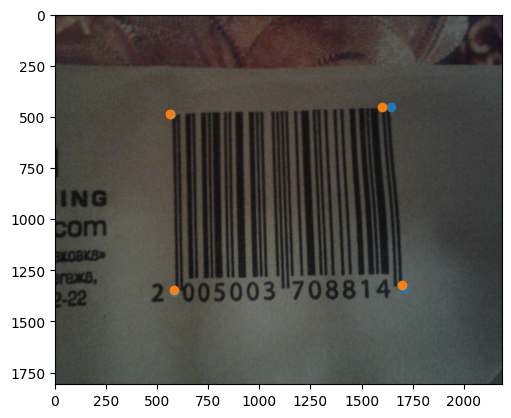

7711af7efa618bf29db3e2ad72ee534a.png


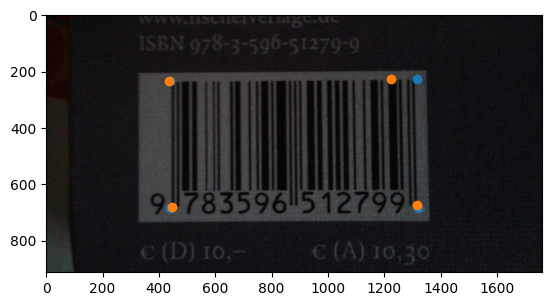

7e56f424b1cd4515c744543907e89663.png


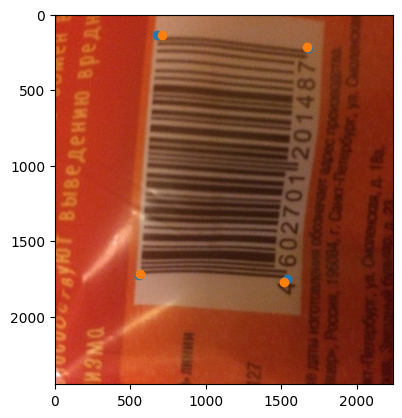

632cf29db1b4cfb252d20edba6508639.png


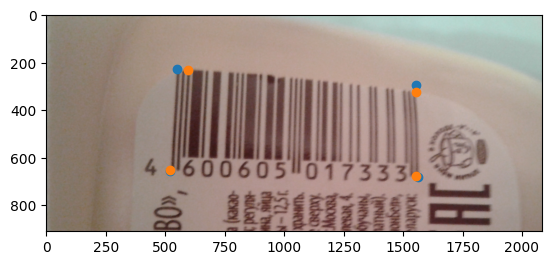

5bff157e9089eae875de1eb057e4ab27.png


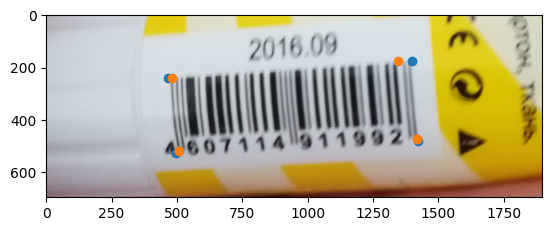

d0adf4fa6ec14c14d53e210a9a279e75.png


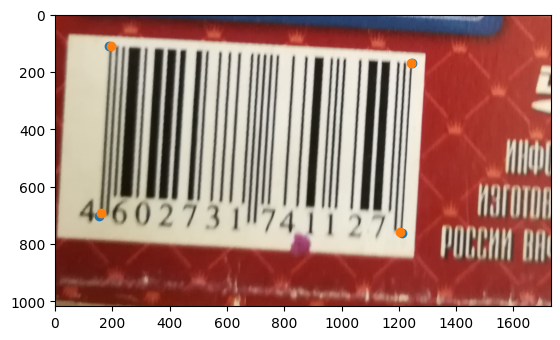

54c516c07afe31075266f04a04d2d03a.png


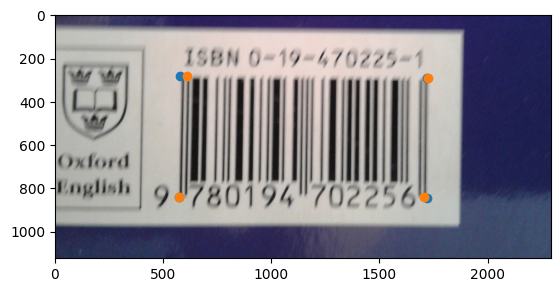

2e83c9d27bbdb98505c76a19f19cb9d7.png


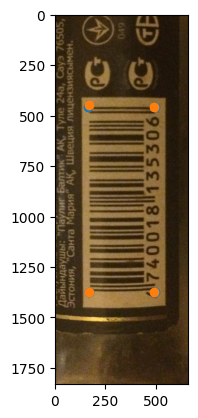

589b454c920322816d8df0494cb07bba.png


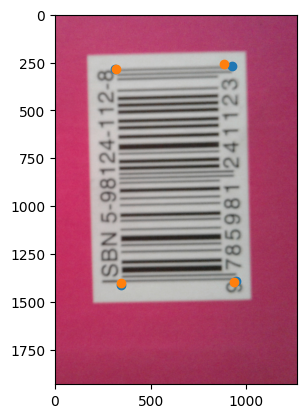

9f627a286049886c0f3232a2469b3cc9.png


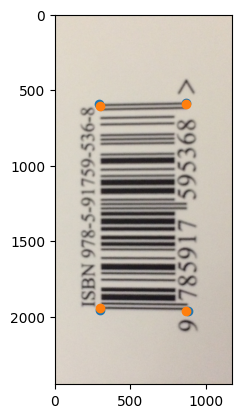

In [ ]:
idx = np.random.randint(0,len(test_dataset), 10)

for i in idx:
  img_id = test_dataset.iloc[i][0]
  gt_sample = test_gt[test_gt['img_id'] == img_id].values.tolist()[0][2:10]
  pred_sample = predictions_df[predictions_df['img_id'] == img_id].values.tolist()[0][2:10]
  print(img_id)
  img = cv2.imread(f'/content/drive/MyDrive/CourseOCRTask3/Test/Images/{img_id}')
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img)
  plt.scatter(gt_sample[::2], gt_sample[1::2])
  plt.scatter(pred_sample[::2], pred_sample[1::2])
  plt.show()

##Подсчет метрики

In [ ]:
%cd /content/course_ocr/task3

/content/course_ocr/task3


In [ ]:
!python3 -m course_ocr_t3.evaluate

Checking answer (/content/course_ocr/task3/answer.csv) against markup(/content/course_ocr/task3/markup.csv)
recognition_accuracy=0.0
detection_result=1.0
score=0.35
